# Miniproject 4

## Imports and Utilities
**Note**: these imports and functions are available in catsoop. You do not need to copy them in.

In [ ]:
from collections import defaultdict
import abc
import numpy as np
import sys
import pdb

def press(event):
  """matplotlib helper function. It processes the keyboard event. If the user hits q, it exit the program."""
  import matplotlib.pyplot as plt
  if event.key == 'q':
    sys.exit(0)
  plt.close()

def plot_value_function(V, mdp):
  """matplotlib helper function. It takes a value function assumed to be a
  maze and plots it.

  Args:
    V: a dict of {(r, c) : value}
  """

  import matplotlib.pyplot as plt
  image = np.zeros((mdp.height, mdp.width))
  for state in V.keys():
    image[state[0], state[1]] = V[state]

  cmap = plt.cm.binary
  norm = plt.Normalize(min(V.values()), max(V.values()))
  rgba = cmap(norm(image))

  for r in range(mdp.height):
    for c in range(mdp.width):
      if (mdp.obstacles[r][c]):
        rgba[r, c, :3] = 1, 0, 0

  if mdp.hazards:
    for hazard in mdp.hazards:
      rgba[hazard[0], hazard[1], :3] = 0, 0, 1

  fig, ax = plt.subplots()
  fig.canvas.mpl_connect('key_press_event', press)
  ax.imshow(rgba)

  #
  # Note that the image coordinates are in (row, column) order, but the plt.arrow
  # command is (x, y). If the rows are y-coordinates, then these two commands
  # use different coordinate conventions. Never mind that image coordinates
  # also have the origin in the top left corner, and is left-handed.
  #
  # Computer graphics has much to answer for.
  #

  for state in V.keys():
    r, c = state
    delta = mdp.action_to_delta(mdp.get_action(V, state))
    plt.arrow(c, r, delta[1]*.35, delta[0]*.35, width = 0.05)

  plt.show()


class MDP:
    """A Markov Decision Process."""

    @property
    @abc.abstractmethod
    def state_space(self):
        """Representation of the MDP state set.
        """
        raise NotImplementedError("Override me")

    @property
    @abc.abstractmethod
    def action_space(self):
        """Representation of the MDP action set.
        """
        raise NotImplementedError("Override me")

    @property
    def temporal_discount_factor(self):
        """Gamma, defaults to 1.
        """
        return 1.

    @property
    def horizon(self):
        """H, defaults to inf.
        """
        return float("inf")

    def state_is_terminal(self, state):
        """Designate certain states as terminal (done) states.

        Defaults to False.

        Args:
            state: A state.

        Returns:
            is_terminal : A bool.
        """
        return False

    @abc.abstractmethod
    def get_reward(self, state, action, next_state):
        """Return (deterministic) reward for executing action
        in state.

        Args:
            state: A current state.
            action: An action.
            next_state: A next state.

        Returns:
            reward : Single time step reward.
        """
        raise NotImplementedError("Override me")

    @abc.abstractmethod
    def get_transition_distribution(self, state, action):
        """Return a distribution over next states.

        The form of this distribution will vary, e.g., depending
        on whether the MDP has discrete or continuous states.

        Args:
            state: A current state.
            action: An action.

        Returns:
            next_state_distribution: Distribution over next states.
        """
        raise NotImplementedError("Override me")

    def sample_next_state(self, state, action, rng=np.random):
        """Sample a next state from the transition distribution.

        This function may be overwritten by subclasses when the explicit
        distribution is too large to enumerate.

        Args:
            state: A state from the state space.
            action: An action from the action space.
            rng: A random number generator.

        Returns:
            next_state: A sampled next state from the state space.
        """
        next_state_dist = self.get_transition_distribution(state, action)
        next_states, probs = zip(*next_state_dist.items())
        next_state_index = rng.choice(len(next_states), p=probs)
        next_state = next_states[next_state_index]
        return next_state

class RescueMDP(MDP):
    """A 2D grid Rescue MDP. We know where the person to be rescued is, and we
    have to go get them."""

    _goal_location = (4, 5)
    goal_reward = 100
    living_reward = 0
    hazard_cost = -100
    hazards = set()
    temporal_discount_factor = .9
    goal_is_terminal = True

    """This is the probability that the action has the intended effect. It
    needs to be <= 1. If it is less than 1, the rest of the probability mass
    is distributed among the other 3 actions. """

    _correct_transition_probability = .97
    _noise_transition_probability = .01

    @property
    def obstacles(self):
      return np.zeros((2, 3))  # by default, 2x3 grid with no obstacles

    @property
    def goal_location(self):
      return self._goal_location

    @goal_location.setter
    def goal_location(self, location):
      assert location[0] < self.width
      assert location[1] < self.height
      assert not self.obstacles[location[0]][location[1]]
      self._goal_location = location

    @property
    def height(self):
      return self.obstacles.shape[0]

    @property
    def width(self):
      return self.obstacles.shape[1]

    @property
    def state_space(self):
      return {(r, c) for r in range(self.height) for c in range(self.width)
              if not self.obstacles[r][c]}

    @property
    def action_space(self):
      return {'up', 'down', 'left', 'right'}

    def action_to_delta(self, action):
      return {
        'up': (-1, 0),  # up,
        'down': (1, 0),  # down,
        'left': (0, -1),  # left,
        'right': (0, 1),  # right,
      }[action]

    def get_action(self, V, s):

      best_value = -float("inf")
      best_action = False

      for a in self.action_space:
        qsa = 0.
        for ns, p in self.get_transition_distribution(s, a).items():
          r = self.get_reward(s, a, ns)
          qsa += p * (r + self.temporal_discount_factor * V[ns])
        if qsa > best_value:
          best_value = qsa
          best_action = a

      return best_action


    @property
    def correct_transition_probability(self):
      return self._correct_transition_probability

    @correct_transition_probability.setter
    def correct_transition_probability(self, prob):
      assert prob >= 0 and prob <= 1

      # This setter function allows the user to specify a probability of an
      # action having the intended effect, e.g., the likelihood that the 'up'
      # action moves the agent 'up'. The probability has to be between 0 and
      # 1. If it is less than 1, all the remaining probability mass is equally
      # distributed among the other three directions.  

      self._correct_transition_probability = prob
      self._noise_transition_probability = (1.0 - prob) / 3.0

    @property
    def noise_transition_probability(self):
      return self._noise_transition_probability

    def get_transition_distribution(self, state, action):
      # Discrete distributions, represented with a dict
      # mapping next states to probs.
      next_state_dist = defaultdict(float)

      if self.state_is_terminal(state):
        return {state: 1.0}

      row, col = state
      for (dr, dc) in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        r, c = row + dr, col + dc
        # Stay in place if out of bounds or obstacle
        if not (0 <= r < self.height and 0 <= c < self.width):
          r, c = row, col
        elif self.obstacles[r, c]:
          r, c = row, col
        next_agent_pos = (r, c)
        if self.action_to_delta(action) == (dr, dc):
          next_state_dist[next_agent_pos] += self.correct_transition_probability
        else:
          next_state_dist[next_agent_pos] += self.noise_transition_probability

      return next_state_dist

    def get_reward(self, state, action, next_state):
      agent_pos = next_state
      if agent_pos == self.goal_location:
        return self.goal_reward
      if self.hazards and next_state in self.hazards:
        return self.hazard_cost
      return self.living_reward

    def state_is_terminal(self, state):
      if not self.goal_is_terminal:
        return False
      return state == self.goal_location

def bellman_backup(s, V, mdp):
  """Look ahead one step and propose an update for the value of s.

  You can assume that the mdp is either infinite or indefinite
  horizon (that is, mdp.horizon is inf).

  Args:
    s: A state.
    V: A dict, V[state] -> value.
    mdp: An MDP.

    Returns:
      vs: new value estimate for s.
  """

  assert mdp.horizon == float("inf")
  vs = -float("inf")
  for a in mdp.action_space:
    qsa = 0.
    for ns, p in mdp.get_transition_distribution(s, a).items():
      r = mdp.get_reward(s, a, ns)
      qsa += p * (r + mdp.temporal_discount_factor * V[ns])
      vs = max(qsa, vs)
  return vs

def value_iteration(mdp, max_num_iters=1000, change_threshold=1e-4):
  """Run value iteration for a certain number of iterations or until
  the max change between iterations is below a threshold.

  You can assume that the mdp is either infinite or indefinite
  horizon (that is, mdp.horizon is inf).

  Args:
    mdp: An MDP.
    max_num_iters: An int representing the maximum number of
    iterations to run value iteration before giving up.
    change_threshold: A float used to determine when value iteration
    has converged and it is safe to terminate.

  Returns:
    V:  A dict, V[state] -> value.
    it: The number of iterations before convergence.
  """

  # Initialize V to all zeros
  V = {s: 0. for s in mdp.state_space}

  for it in range(max_num_iters):
    next_V = {}
    max_change = 0.
    for s in mdp.state_space:
      if mdp.state_is_terminal(s):
        next_V[s] = 0.
      else:
        next_V[s] = bellman_backup(s, V, mdp)
      max_change = max(abs(next_V[s] - V[s]), max_change)

    V = next_V

    if max_change < change_threshold:
      break

  return V, it


class SmallRescueMDP(RescueMDP):
  """A small 2D grid MDP."""

  goal_location = (0, 0)
  @property
  def obstacles(self):
    return np.array([
      [0, 0, 0, 0, 0],
      [0, 0, 0, 1, 0],
      [0, 0, 0, 1, 0],
      [0, 1, 0, 1, 1]
      ])

class LargeRescueMDP(RescueMDP):
  """A larger 2D grid MDP."""

  @property
  def obstacles(self):
    return np.array([
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
      [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
      [0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
      [0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
      [0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      ])



## Problems

### Warmup 1

We have provided a new RescueMDP class for you, that models the robot's motion
as noisy. This class is in many ways similar to the ChaseMDP class in homework
7, in that it is a maze MDP with obstacles. However, there's just the one
agent (the robot, no bunny).

Recall that an MDP is defined by the following tuple:
* States: The state space is a set of coordinates. The set is defined over a
grid, but states that aren't obstacles aren't in the state space.
* Actions: The robot can take four actions, up, down, left, right.
* A transition function: The probability the action succeeds at moving the
robot in the given direction is given by the class field
`correct_transition_probability`. If this probability is less than 1, then the
rest of the probability mass is uniformly distributed among the other three
directions. Any probability mass for a motion that would move the robot into
an obstacle or out of the map is mapped to the robot staying the same
place. If the robot is in the goal state and the MDP has the flag
`goal_is_terminal = True`, it cannot transition out of the goal state. If the flag
`goal_is_terminal = False`, the robot is free to leave the goal state and
re-enter it.
* Reward function: The robot gets a reward of `living_reward` for each action
it takes. It gets reward of `goal_reward` every time it enters the goal
state.

Let's begin solving a small version of the RescueMDP. The maze is 4x5 ---
remember that arrays are row-major order, that is, the arrays are indexed by
(row, column). The person to be rescued (goal_location) is at (0, 0).

In the first warmup problem, please solve
for the optimal value function for this problem. We have provided the reference
implementation for value iteration.

We also want you to be able to examine the policy that results from solving
for the optimal value function. Please use the helper function
`plot_value_function` to generate a plot of both the value function and the
corresponding policy.

<!-- first_experiment() -->
<div class="question question-multiplechoice">
<b>Submission Material 1:</b> In your submitted pdf, please include a single
plot of the value function with the action under the optimal policy drawn for
each state. Name this figure as Figure 1.
</div>


For reference, our solution is **3** lines of code.

In [ ]:
def warmup_1():
  """Creates a SmallRescueMDP() and returns the optimal value function.

  Args:
    None

  Returns:
    value function: a dict of states to values
  """
  mdp = SmallRescueMDP()
  re = value_iteration(mdp)
  print(re)
  plot_value_function(re[0],mdp)
  return re[0]


Tests

({(0, 1): 99.50024542567529, (1, 2): 80.04025632412159, (3, 2): 64.440383547797, (0, 0): 0.0, (3, 0): 79.94774469404808, (1, 0): 99.50025184467293, (2, 2): 71.82187169836179, (1, 4): 64.17423641835612, (2, 1): 80.04026274311923, (2, 0): 89.1055619783276, (1, 1): 89.19994673349667, (2, 4): 57.578723372930945, (0, 4): 71.59323394182438, (0, 3): 79.87054749786864, (0, 2): 89.10485517953946}, 14)


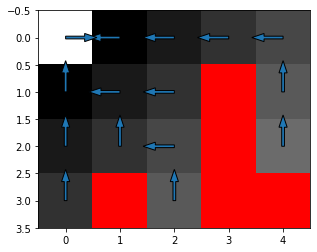

Tests passed.


In [ ]:
import random; import numpy.random; random.seed(0); numpy.random.seed(0);
assert warmup_1() == {(0, 1): 99.50024542567529, (1, 2): 80.04025632412159, (3, 2): 64.440383547797, (0, 0): 0.0, (3, 0): 79.94774469404808, (1, 0): 99.50025184467293, (2, 2): 71.82187169836179, (1, 4): 64.17423641835612, (2, 1): 80.04026274311923, (2, 0): 89.1055619783276, (1, 1): 89.19994673349667, (2, 4): 57.578723372930945, (0, 4): 71.59323394182438, (0, 3): 79.87054749786864, (0, 2): 89.10485517953946}
print('Tests passed.')

### Warmup 2
Please hand-code a list of actions that will get the robot from (3,2) to the goal location (0, 0) under the optimal policy, if `correct_transition_probability = 1.0`. This should be a python list of actions, e.g., [down, down, down, down].

For reference, our solution is **2** lines of code.

In [ ]:
def warmup2():
  """Hand-code a list of actions that the robot will take under the optimal
  policy from a start state of (3, 2) to the goal state of (0, 0), if
  `correct_transition_probability = 1.0`.

  Returns:
    actions: A list of str actions that get the robot to the goal state.
  """
  return ['up','left','up','left','up']

Tests

In [ ]:
def warmup2_test():
  mdp = SmallRescueMDP()
  mdp.correct_transition_probability = 1.0
  state = (3, 2)
  actions = warmup2()
  for action in actions:
    state = mdp.sample_next_state(state, action)
  assert state == (0, 0)

warmup2_test()
print('Tests passed.')

Tests passed.


### MDP Question 2

In the MDP class we have provided, the goal state is a terminal state. Once
the agent is in the terminal state, it can't leave and it doesn't receive any
more reward. Let's investigate what happens if we don't make the goal state a
terminal state.

Please create a SmallRescueMDP, set the goal_is_terminal to be False, and
compute the value function.

<div class="question question-multiplechoice">
<b>Submission Material 2:</b> In your submitted pdf, please include a single
plot of the value function with the action under the optimal policy drawn for
each state. Name this figure as Figure 2.

In your pdf, please also answer the following questions:

* Compared to the previous question, you should have seen the number of
iterations change before value iteration converged. Why is that? What extra
work are we making value iteration do in this case?

* At the same time, the optimal policy did not change anywhere except possibly
the goal. (In this and the following questions, when we ask you to compare
policies, we want you to ignore the goal state.) Why is the policy the same,
even though it took more iterations to converge?

* Is there some property of the reward function in general for MDPs that makes
solving for the optimal policy with value iteration easier or harder?

</div>


For reference, our solution is **5** lines of code.

In [ ]:
def MDP_2():
  """Creates a SmallRescueMDP(), sets goal_is_terminal to False and returns the optimal value function.

  Args:
    None

  Returns:
    value function: a dict of states to values
    it: the number of iterations required to solve for the value function
  """
  mdp = SmallRescueMDP()
  mdp.goal_is_terminal = False
  re = value_iteration(mdp)
  plot_value_function(re[0],mdp)
  print(re)
  return re
  #number of iteration 14 --> 131
  #consider whether it would be good to leave goal state and comeback again to gain more rewards


Tests

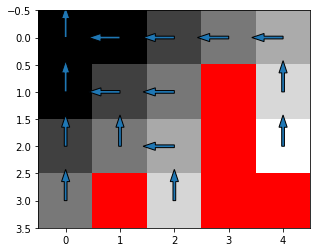

({(0, 1): 976.6314991080653, (1, 2): 785.624375483249, (3, 2): 632.5057580306595, (0, 0): 979.4854087102677, (3, 0): 784.7163389217253, (1, 0): 976.631562112438, (2, 2): 704.957837213064, (1, 4): 629.8934334526643, (2, 1): 785.6244384876218, (2, 0): 874.6037652852367, (1, 1): 875.5301872186959, (2, 4): 565.1560925806813, (0, 4): 702.7136725549406, (0, 3): 783.9586195544681, (0, 2): 874.5968278037411}, 131)
Tests passed.


In [ ]:
import random; import numpy.random; random.seed(0); numpy.random.seed(0);
assert MDP_2() == ({(0, 1): 976.6314991080653, (1, 2): 785.624375483249, (3, 2): 632.5057580306595, (0, 0): 979.4854087102677, (3, 0): 784.7163389217253, (1, 0): 976.631562112438, (2, 2): 704.957837213064, (1, 4): 629.8934334526643, (2, 1): 785.6244384876218, (2, 0): 874.6037652852367, (1, 1): 875.5301872186959, (2, 4): 565.1560925806813, (0, 4): 702.7136725549406, (0, 3): 783.9586195544681, (0, 2): 874.5968278037411}, 131)
print('Tests passed.')

### MDP Question 3

Let's now turn our attention to a larger MDP. Please create a LargeRescueMDP
and compute the optimal value function.

<div class="question question-multiplechoice">
<b>Submission Material 3:</b> In your submitted pdf, please include a single
plot of the value function with the action under the optimal policy drawn for
each state. Name this figure as Figure 3.
</div>


For reference, our solution is **3** lines of code.

In [ ]:
def MDP_3():
  """Creates a LargeRescueMDP(), and returns the optimal value function and
  number of iterations required to converge

  Args:
    None

  Returns:
    value function: a dict of states to values
    it: the number of iterations required to solve for the value function
  """
  mdp = LargeRescueMDP()
  re = value_iteration(mdp)
  plot_value_function(re[0],mdp)
  print(re)
  return re

Tests

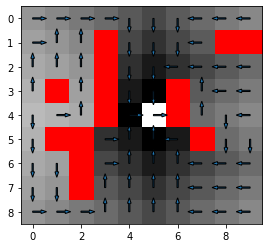

({(5, 9): 51.427184372629654, (4, 7): 57.24942466484467, (6, 9): 57.31044771948743, (7, 3): 64.38378339850985, (4, 8): 51.477861619010575, (3, 0): 29.997978602266883, (2, 8): 63.866697606203566, (5, 6): 89.10343277693175, (6, 6): 79.87591094828778, (8, 0): 41.56749854170138, (7, 7): 64.1906123496321, (0, 7): 57.53968483878395, (2, 1): 37.294652947208995, (8, 9): 46.46228722379235, (1, 6): 71.46317864388475, (3, 7): 63.866705918797976, (0, 3): 57.81353882364696, (2, 5): 89.01900243377555, (8, 5): 71.26442203181726, (2, 4): 80.11518850941486, (5, 8): 57.30901926222007, (4, 0): 26.97240030571446, (1, 2): 46.361654557652294, (4, 9): 46.28196469917531, (5, 5): 99.40514065110256, (2, 9): 57.24850935593198, (6, 7): 71.52909705147924, (8, 1): 46.37295740578368, (7, 6): 71.6037666010765, (4, 4): 99.50187546410399, (6, 3): 71.75171813607103, (1, 5): 79.64569348621423, (5, 0): 30.00062894204498, (0, 4): 64.49822454430208, (2, 2): 41.5179757146076, (8, 6): 64.24856551191186, (4, 1): 29.90300033148

In [ ]:
import random; import numpy.random; random.seed(0); numpy.random.seed(0);
assert MDP_3() == ({(5, 9): 51.427184372629654, (4, 7): 57.24942466484467, (6, 9): 57.31044771948743, (7, 3): 64.38378339850985, (4, 8): 51.477861619010575, (3, 0): 29.997978602266883, (0, 2): 51.77167752199026, (2, 8): 63.866697606203566, (5, 6): 89.10343277693175, (6, 6): 79.87591094828778, (7, 7): 64.1906123496321, (0, 7): 57.53968483878395, (2, 1): 37.294652947208995, (8, 0): 41.56749854170138, (8, 9): 46.46228722379235, (1, 6): 71.46317864388475, (3, 7): 63.866705918797976, (0, 3): 57.81353882364696, (2, 5): 89.01900243377555, (8, 5): 71.26442203181726, (5, 8): 57.30901926222007, (4, 0): 26.97240030571446, (1, 2): 46.361654557652294, (4, 9): 46.28196469917531, (5, 5): 99.40514065110256, (2, 9): 57.24850935593198, (6, 7): 71.52909705147924, (8, 1): 46.37295740578368, (7, 6): 71.6037666010765, (4, 4): 99.50187546410399, (6, 3): 71.75171813607103, (1, 5): 79.64569348621423, (5, 0): 30.00062894204498, (2, 2): 41.5179757146076, (0, 4): 64.49822454430208, (8, 6): 64.24856551191186, (4, 1): 29.90300033148703, (1, 1): 41.5626015183776, (6, 4): 79.96208134752649, (3, 2): 37.21529472183023, (0, 0): 41.55773396442767, (2, 6): 79.71607202444552, (5, 4): 89.19904388402188, (8, 2): 51.784353648073704, (7, 1): 41.52806356045833, (4, 5): 0.0, (6, 0): 33.4683494865608, (1, 4): 71.88481819474575, (3, 9): 51.378797571401286, (0, 5): 71.33026555348314, (7, 5): 79.57152694202794, (8, 7): 57.651153477926165, (4, 2): 33.35853220876574, (1, 0): 37.29501402141274, (0, 8): 51.577016904150774, (6, 5): 88.9353734615529, (3, 5): 99.50024037525212, (0, 1): 46.36201563185604, (2, 7): 71.31884930507499, (5, 3): 79.95573398571852, (7, 8): 57.5446502393624, (7, 0): 37.29908558822458, (6, 8): 63.99437878087923, (7, 9): 51.63515062834477, (8, 3): 57.77191141593772, (6, 1): 37.22526933032567, (3, 8): 57.25614447733788, (0, 6): 64.12430323875384, (2, 0): 33.465368707503046, (7, 4): 71.6813569329961, (8, 8): 51.73109931662876, (1, 7): 64.12419955940373, (0, 9): 46.27619295995178, (3, 4): 89.28524333009564, (2, 4): 80.11518850941486, (8, 4): 64.31801372707054}, 22)
print('Tests passed.')

### MDP Question 4

The default transition model for the LargeRescueMDP is pretty close
to deterministic. There is a .97 chance that each action succeeds in the intended
direction (unless there's an obstacle in the way or its the edge of the map)
and only a .01 chance of ending up in one of the other 3 neighbouring grid
cells.

What happens if we make the transition model noisier? Setting the
correct_transition_probability to .76 is not too noisy, but it has
implications for our ability to solve for the optimal policy.

Please create a LargeRescueMDP and set the correct_transition_probability to
be .76. You can set the correct_transition_probability field of the
LargeRescueMDP class directly, and the transition function will be adjusted
according. (You can read the comment in the LargeRescueMDP setter function for
more detail on how setting the correct_transition_probability works.)

<div class="question question-multiplechoice">
<b>Submission Material 4:</b> In your submitted pdf, please include a single
plot of the value function with the action under the optimal policy drawn for
each state. Name this figure as Figure 4.

In your pdf, please also answer the following questions:

* Compared to the previous question, you should have seen the number of
iterations change before value iteration converged. Why is that? What extra
work are we making value iteration do in this case?

<!-- Because the motion to the next state is noisy, it can take more steps to get
to the goal. Value iteration converges when the expected reward of the policy
from each state to the goal has been computed. Since it takes more steps to
get to the goal, it takes more iterations to compute the expected reward. -->

* At the same time, the optimal policy did not change. Why didn't the policy
change under the noisy dynamics?

<!-- There isn't a way for the agent to compensate for the noisy dynamics, so
there's no change to the policy that could improve the progress towards the
goal. -->

* You should have seen the value function decrease in nearly all cells. Why
did it go down? Where is the loss in value coming from?

<!-- The loss in value at each state comes from the fact that more actions are
likely to be required to get to the goal, and so the value of the goal state
is likely to be discounted more, and the discounted expected value
of a sequence of actions will be reduced. -->

* What would happen to the number of iterations, to the policy, and to the
value function if the dynamics were even noisier, say
correct_transition_probability was set to 0.5?

<!-- The number of iterations would go up, the value function would be reduced
further, but the policy would not change. -->

</div>


For reference, our solution is **4** lines of code.

In [ ]:
def MDP_4():
  """Creates a LargeRescueMDP(), sets the correct_transition_probability to
  .76 and returns the optimal value function and
  number of iterations required to converge

  Args:
    None

  Returns:
    value function: a dict of states to values
    it: the number of iterations required to solve for the value function
  """
  mdp = LargeRescueMDP()
  mdp.correct_transition_probability = 0.76
  re = value_iteration(mdp)
  plot_value_function(re[0],mdp)
  print(re[1])
  return re
  # to figure out the random part so have to do more iteartions
  # did not change beacuse correct > 0.5 so will still go toward the optimal state
  # decrease because the 0.19 probability that it goes to a cell with lower value
  # iteration increase, value decrease, policy stays the same, if probability = 0.25 --> pure guess

Tests

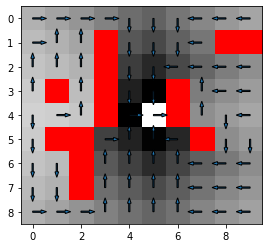

41
Tests passed.


In [ ]:
import random; import numpy.random; random.seed(0); numpy.random.seed(0);
assert MDP_4() == ({(5, 9): 37.09563198565326, (4, 7): 41.79958505037646, (6, 9): 42.379150021338276, (7, 3): 53.62383581844224, (4, 8): 37.33611818768401, (3, 0): 19.184941573721872, (0, 2): 39.54500010633741, (2, 8): 48.37609286765003, (5, 6): 80.39156750674351, (6, 6): 69.17350279458515, (7, 7): 51.413594478870216, (0, 7): 44.47885137481426, (2, 1): 25.397822670558156, (8, 0): 29.485520779767217, (8, 9): 34.81853504895561, (1, 6): 58.371006293552576, (3, 7): 48.38047730522361, (0, 3): 46.568742068171915, (2, 5): 79.50785163099987, (8, 5): 57.16960149114739, (5, 8): 42.2743189133091, (4, 0): 17.193656448413645, (1, 2): 33.63013421547188, (4, 9): 33.24527236077266, (5, 5): 93.32556960074426, (2, 9): 41.7430747582296, (6, 7): 58.8166743393827, (8, 1): 34.191129369373066, (7, 6): 59.54114719666043, (4, 4): 94.63963415294967, (6, 3): 61.46654014072949, (1, 5): 67.23721597706378, (5, 0): 19.36445038655641, (2, 2): 28.67493693106001, (0, 4): 54.116379728735176, (8, 6): 51.83291668257821, (4, 1): 18.46056909239355, (1, 1): 29.10269089376744, (6, 4): 70.24275282935724, (3, 2): 24.704121310787116, (0, 0): 29.033502757353006, (2, 6): 67.54061291729131, (5, 4): 81.57596106315178, (8, 2): 40.21565223450838, (7, 1): 29.15147584428534, (4, 5): 0.0, (6, 0): 22.424055347153732, (1, 4): 62.444310480187774, (3, 9): 36.70592766228915, (0, 5): 57.71031630612815, (7, 5): 66.56559260006958, (8, 7): 45.25820887982636, (4, 2): 21.29292539099053, (1, 0): 25.425642667196094, (0, 8): 38.3562257828573, (6, 5): 78.66538264988357, (3, 5): 94.47917738184584, (0, 1): 33.657954212109814, (2, 7): 56.82786088085701, (5, 3): 70.35461243079723, (7, 8): 44.3619253645486, (7, 0): 25.734404278265206, (6, 8): 49.519712872964426, (7, 9): 38.68727231509817, (8, 3): 46.729294692291475, (6, 1): 25.180061683772845, (3, 8): 41.906350224012456, (0, 6): 50.95192651060614, (2, 0): 22.19943115828667, (7, 4): 60.490236730134086, (8, 8): 39.50173149602546, (1, 7): 50.88346010072386, (0, 9): 33.46384586176194, (3, 4): 82.66821248865962, (2, 4): 71.94570365595851, (8, 4): 52.64659733120905}, 41)
print('Tests passed.')

### MDP Question 5

The default temporal_discount_factor is .9. This is in general quite a low
discount factor. An action 20 steps away will have $.9^{20} \approx .12$ impact on later
actions.

What happens if we increase the discount factor? Please create a
LargeRescueMDP, set the temporal_discount_factor to be .99, and also set
the correct_transition_probability to be .76. Then please solve for the
optimal value function.

<div class="question question-multiplechoice">
<b>Submission Material 5:</b> In your submitted pdf, please include a single
plot of the value function with the action under the optimal policy drawn for
each state. Name this figure as Figure 5.

In your pdf, please also answer the following questions:

* Compared to the previous question, you should have seen the number of
iterations increase before value iteration converged. Why is that? What
extra work are we making value iteration do in this case?

<!-- This is a subtle question. If the value of a state is the expected return
of a discounted sequence of rewards, the value function converges when we've
done enough backups that the effect of one more backup and one more discounted
reward is no longer measurable numerically. When we make the value function
close to one, then it takes a longer sequence of backups for the discounted
reward to no longer be measurable numerically. -->

* At the same time, the optimal policy did not change. Why is the policy the
same, but it took more iterations to converge?

<!-- There's no reason to do anything different, we're just making the value
function compute the expected value of a longer sequence of possible outcomes
under the policy. -->

* You should have seen the value function increase in nearly all cells. Why
did it go up? Where did the increase in value come from?

<!-- The increase in value came from the fact that we're not down-weighting
the future as much. For the same sequence of actions, we expect to get a
higher reward because we value the future more. -->

* What would happen to the number of iterations, to the policy, and to the
value function if we left the temporal_discount_factor at .99 but made the
dynamics fairly deterministic again, say correct_transition_probability = .99?
(You should try this!)

<!-- The number of iterations will go down because the path is nearly
deterministic now --- from each state, the policy will get to the goal in
(mostly) a fixed number of steps. The fact that we can take expectations over
longer sequences of actions doesn't change the value function or make us
compute more iterations because once we get to the goal, we get no more
reward. The policy won't change, but the value function will stay high. -->

</div>


For reference, our solution is **5** lines of code.

In [ ]:
def MDP_5():
  """Creates a LargeRescueMDP(), sets the correct_transition_probability to
  .76 and the temporal_discount_factor to .99 and returns the optimal value function and
  number of iterations required to converge

  Args:
    None

  Returns:
    value function: a dict of states to values
    it: the number of iterations required to solve for the value function
  """
  mdp = LargeRescueMDP()
  mdp.correct_transition_probability = 0.9
  mdp.temporal_discount_factor = 0.99
  re = value_iteration(mdp)
  plot_value_function(re[0],mdp)
  print(re[1])
  return re

Tests

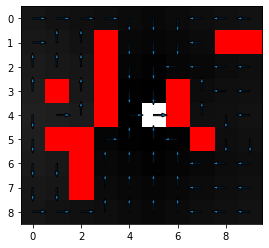

32


AssertionError: ignored

In [ ]:
import random; import numpy.random; random.seed(0); numpy.random.seed(0);
assert MDP_5() == ({(5, 9): 90.49294151104122, (4, 7): 91.53586068943369, (6, 9): 91.67470906173104, (7, 3): 93.97491750094179, (4, 8): 90.54408402590663, (3, 0): 84.8709760689106, (0, 2): 91.15195158169959, (2, 8): 92.85540170289251, (5, 6): 97.7688940677295, (6, 6): 96.30174912325705, (7, 7): 93.49470937074302, (0, 7): 92.17514466317554, (2, 1): 87.23080746083865, (8, 0): 88.55907148092525, (8, 9): 90.02820552034618, (1, 6): 94.66146525243018, (3, 7): 92.85684581202082, (0, 3): 92.67280996413947, (2, 5): 97.64083406000782, (8, 5): 94.47412332570079, (5, 8): 91.64279788012988, (4, 0): 84.0088571825647, (1, 2): 89.67672656160515, (4, 9): 89.54219638658633, (5, 5): 99.22275748726061, (2, 9): 91.51907133407133, (6, 7): 94.7388560346764, (8, 1): 89.85966251042251, (7, 6): 94.86949260973816, (4, 4): 99.39679280725164, (6, 3): 95.24349019068275, (1, 5): 96.0088117943946, (5, 0): 84.979923830497, (2, 2): 88.2596929505786, (0, 4): 94.06459700794483, (8, 6): 93.58873399735727, (4, 1): 84.52926790610293, (1, 1): 88.40199915122935, (6, 4): 96.47708368340508, (3, 2): 86.97078685302058, (0, 0): 88.39225620136497, (2, 6): 96.04265401195448, (5, 4): 97.92940667071218, (8, 2): 91.34026747888913, (7, 1): 88.4404389970416, (4, 5): 0.0, (6, 0): 86.21161978985722, (1, 4): 95.40750777342734, (3, 9): 90.3793968171442, (0, 5): 94.57557687282643, (7, 5): 95.897070647761, (8, 7): 92.35290042089164, (4, 2): 85.70758382182571, (1, 0): 87.24220975351437, (0, 8): 90.84234985893639, (6, 5): 97.51833426545349, (3, 5): 99.37197204832822, (0, 1): 89.68812885428089, (2, 7): 94.36773185735558, (5, 3): 96.51303468508517, (7, 8): 92.13682235192404, (7, 0): 87.385190483955, (6, 8): 93.09749758158448, (7, 9): 90.91508992377925, (8, 3): 92.71010661836499, (6, 1): 87.17982482641227, (3, 8): 91.54877634429582, (0, 6): 93.41218842117453, (2, 0): 86.08978494897735, (7, 4): 95.05380837452687, (8, 8): 91.131398346243, (1, 7): 93.39431118581003, (0, 9): 89.65081472852465, (3, 4): 98.08785113514071, (2, 4): 96.75361408485887, (8, 4): 93.77006553865067}, 52)
print('Tests passed.')

### MDP Question 6

Let's make the problem a little harder. In addition to obstacles, our
RescueMDP class supports hazards, which are states that have a penalty for
entering.

Let's start with relatively noise-free dynamics and add some hazards. You can
add hazards to the LargeRescueMDP simply by setting the LargeRescueMDP.hazard
field to be a set of states, for example `mdp.hazards = {(0, 0)}` would put a
hazard at (0,0. The default cost of entering a hazard is -100, and is given by
the hazard_cost field. 

Please create a LargeRescueMDP and set a hazard at `{(1, 4)}', and then please
solve for the optimal value function.

<div class="question question-multiplechoice">
<b>Submission Material 6:</b> In your submitted pdf, please include a single
plot of the value function with the action under the optimal policy drawn for
each state. Name this figure as Figure 6.

In your pdf, please also answer the following questions:

* Compared to question three (LargeRescueMDP, discount factor = .9,
correct_transition_probability = .97, no hazards), the number of iterations to
solve for the optimal value function should be more or less the same, and the
policy is the same too. Why didn't the hazard change the policy or require
more iterations?

<!-- The location of the hazard wasn't on the most likely path to the goal for
most states, and with nearly-deterministic dynamics, there was rarely a need
to react to the hazard. -->

* You should have seen the value function decrease a little bit some but not
all states. Where did the value function change and why?

<!-- The states where the expected trajectory took the agent past the hazard
saw a small reduction in value, due to the small chance that the stochastic
dynamcs would take the agent into the hazard, e.g. (0, 0). The states where
the expected trajectory took the agent nowhere near the hazard saw no change
in value because for those states, the problem looks exactly the same as
before. -->

</div>


For reference, our solution is **4** lines of code.

In [ ]:
def MDP_6():
  """Creates a LargeRescueMDP(), and sets a hazard at `{(1, 4)}' and returns
  the optimal value function and number of iterations required to converge

  Args:
    None

  Returns:
    value function: a dict of states to values
    it: the number of iterations required to solve for the value function
  """
  mdp = LargeRescueMDP()
  mdp.hazards={(1,4)}
  re = value_iteration(mdp)
  plot_value_function(re[0],mdp)
  print(re[0])
  return re

Tests

In [ ]:
import random; import numpy.random; random.seed(0); numpy.random.seed(0);
assert MDP_6() == ({(5, 9): 51.4271812347034, (4, 7): 57.237127427243394, (6, 9): 57.31044726342647, (7, 3): 64.38372836208332, (4, 8): 51.477635375789845, (3, 0): 28.91022772097015, (0, 2): 49.87899851828126, (2, 8): 63.852866407268095, (5, 6): 89.10343214022201, (6, 6): 79.87591037175028, (7, 7): 64.19061187724434, (0, 7): 57.51957673822181, (2, 1): 35.931228133531285, (8, 0): 41.5674630159361, (8, 9): 46.46228687265828, (1, 6): 71.43831962228903, (3, 7): 63.85287561968652, (0, 3): 55.69998028763845, (2, 5): 88.99991706193646, (8, 5): 71.26442007162068, (5, 8): 57.30901675493411, (4, 0): 26.9524897686632, (1, 2): 44.666756202629855, (4, 9): 46.28166592380871, (5, 5): 99.40513994083895, (2, 9): 57.236113037706396, (6, 7): 71.52909653492864, (8, 1): 46.37291777318745, (7, 6): 71.60376607415502, (4, 4): 99.50178865637716, (6, 3): 71.75165679504416, (1, 5): 78.60277616305036, (5, 0): 30.000419521027403, (2, 2): 40.00015346480367, (0, 4): 62.14028597507123, (8, 6): 64.24856502597086, (4, 1): 28.818721808380296, (1, 1): 40.04314783546555, (6, 4): 79.9620129943958, (3, 2): 35.85477108447975, (0, 0): 40.03845822844368, (2, 6): 79.69889313860072, (5, 4): 89.19896685795916, (8, 2): 51.784309390648424, (7, 1): 41.52802806825521, (4, 5): 0.0, (6, 0): 33.46831919974154, (1, 4): 69.93279454298973, (3, 9): 51.36784781412655, (0, 5): 70.38983783260075, (7, 5): 79.57152527766405, (8, 7): 57.65115304200534, (4, 2): 32.13908555793158, (1, 0): 35.93157600803734, (0, 8): 51.55899254675166, (6, 5): 88.93537220614647, (3, 5): 99.49998093875435, (0, 1): 44.66710407713591, (2, 7): 71.30340318704978, (5, 3): 79.95566494720325, (7, 8): 57.54464981569043, (7, 0): 37.299053695108135, (6, 8): 63.994378299447376, (7, 9): 51.63515024778938, (8, 3): 57.77186204125601, (6, 1): 37.225237500031014, (3, 8): 57.24384556140725, (0, 6): 64.0936808893615, (2, 0): 32.242015775844905, (7, 4): 71.68129626521419, (8, 8): 51.73109892557712, (1, 7): 64.10197764838253, (0, 9): 46.260021054341685, (3, 4): 89.27576186090349, (2, 4): 79.07985318770224, (8, 4): 64.31795981689137}, 22)
print('Tests passed.')

NameError: ignored

### MDP Question 7

Given the hazards, let's make the dynamics noisier. Please create a
LargeRescueMDP, set a hazard at `{(1, 4)}' and set
correct_transition_probability to be .76. Then please solve for the optimal
value function.

<div class="question question-multiplechoice">
<b>Submission Material 7:</b> In your submitted pdf, please include a single
plot of the value function with the action under the optimal policy drawn for
each state. Name this figure as Figure 7.

In your pdf, please also answer the following questions:

* Compared to the previous question, with these noisier dynamics, the policy
changed slightly. Please enumerate which states had a different policy
relative to the previous question. Why did the policy change?

<!-- The policy changed in states (4,1) and (3,0). For those two states, the
risk of encountering the hazard, and the associated penalty, increased enough
relative to the last problem that it made more sense to go down and around the
red obstacle, rather than up and over. Those two states were right on the
borderline of whether the higher value policy was to go up and over or down
and under. When the dynamics are deterministic,
it's cheaper to go up and over. The increased noise made it cheaper to go down
and under and avoid the hazard.

-->

</div>


For reference, our solution is **5** lines of code.

In [ ]:
def MDP_7():
  """Creates a LargeRescueMDP(), and sets a hazard at `{(1, 4)}' and
  correct_transition_probability to 0.76 and returns
  the optimal value function and number of iterations required to converge

  Args:
    None

  Returns:
    value function: a dict of states to values
    it: the number of iterations required to solve for the value function
  """
  mdp = LargeRescueMDP()
  mdp.correct_transition_probability = 0.76
  mdp.hazard={(1,4)}
  re = value_iteration(mdp)
  plot_value_function(re[0],mdp)
  print(re[1])
  return re

Tests

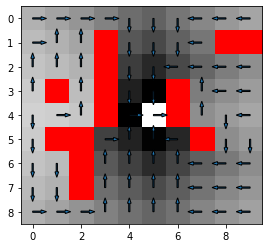

41


AssertionError: ignored

In [ ]:
import random; import numpy.random; random.seed(0); numpy.random.seed(0);
assert MDP_7() == ({(5, 9): 37.076292959818325, (4, 7): 40.83813183108957, (6, 9): 42.37421631594617, (7, 3): 53.58587767303377, (4, 8): 37.172043443451535, (3, 0): 14.257080008555057, (0, 2): 23.625248935468903, (2, 8): 47.18567426829294, (5, 6): 80.38711084547492, (6, 6): 69.16933401697958, (7, 7): 51.41009372308178, (0, 7): 42.76223519394684, (2, 1): 15.194257059215063, (8, 0): 29.464930567865483, (8, 9): 34.81591698394303, (1, 6): 56.19070432671395, (3, 7): 47.1945244940078, (0, 3): 27.821316799452603, (2, 5): 77.6999307180308, (8, 5): 57.16022349066624, (5, 8): 42.25687975685694, (4, 0): 16.421615312436046, (1, 2): 20.092131935826522, (4, 9): 33.06030764216262, (5, 5): 93.32043106439409, (2, 9): 40.72406229799357, (6, 7): 58.81299231679303, (8, 1): 34.167297224633714, (7, 6): 59.537106911853044, (4, 4): 94.5641035327204, (6, 3): 61.42243352991348, (1, 5): 56.60185168270668, (5, 0): 19.282480765779034, (2, 2): 17.13538519584927, (0, 4): 32.330452770174745, (8, 6): 51.82894519914158, (4, 1): 14.216277331359992, (1, 1): 17.390057902997512, (6, 4): 70.19589512881367, (3, 2): 14.786679269924562, (0, 0): 17.34747457582023, (2, 6): 65.92979958043715, (5, 4): 81.51688868694201, (8, 2): 40.18763180291005, (7, 1): 29.131080075189374, (4, 5): 0.0, (6, 0): 22.402728137328516, (1, 4): 44.11227940827055, (3, 9): 35.899960921702124, (0, 5): 47.98748742696508, (7, 5): 66.55655217502897, (8, 7): 45.254779609451575, (4, 2): 13.011249138557904, (1, 0): 15.210712460919861, (0, 8): 36.875907688262316, (6, 5): 78.65754308537763, (3, 5): 94.26796024079891, (0, 1): 20.108587337531326, (2, 7): 55.42181595705876, (5, 3): 70.30369984452659, (7, 8): 44.3587953545662, (7, 0): 25.715993813972673, (6, 8): 49.515358476256225, (7, 9): 38.68438005068324, (8, 3): 46.69673648959218, (6, 1): 25.161974192802585, (3, 8): 40.93960654748059, (0, 6): 48.45735082995887, (2, 0): 13.496334755675049, (7, 4): 60.45256893947166, (8, 8): 39.498758433002976, (1, 7): 49.03415216123638, (0, 9): 32.17234626675661, (3, 4): 81.75377908038084, (2, 4): 61.088431047057576, (8, 4): 52.61557995834015}, 42)
print('Tests passed.')

### MDP Question 8

Now let's make the dynamics really noisy. Once again, please create a
LargeRescueMDP with a hazard at `{(1, 4)}', but with
correct_transition_probability set to 0.5. You should see a very substantial
change in both the policy and value function. 

<div class="question question-multiplechoice">
<b>Submission Material 8:</b> In your submitted pdf, please include a single
plot of the value function with the action under the optimal policy drawn for
each state. Name this figure as Figure 8.

In your pdf, please also answer the following questions:

* Compared to the previous question, with these much noisier dynamics, the
policy changed a lot. Where did the policy change (you don't need to
enumerate states, just give a general description) and why?

<!-- The policy changed in the top left. It's cheaper now for all the states
to the left of (0, 4) to go down and around, to avoid the large negative
hazard.
-->

* At the state (0, 3), you should see that the policy from state (0, 3)
actually goes to the left, even though it's a much shorter path to the goal
to go right. To the nearest 1/100th, what is the lowest value of
correct_transition_probability before the agent starts heading left from
(0, 3)? (We're expecting you to work this out experimentally, not derive the
answer mathematically.) 

<!-- 0.59. The agent heads right from (0, 3) for values of
correct_transition_probability at .59 or greater. .58 or lower, it heads left.
-->

</div>


For reference, our solution is **5** lines of code.

In [ ]:
def MDP_8():
  """Creates a LargeRescueMDP(), and sets a hazard at `{(1, 4)}' and
  correct_transition_probability to 0.5 and returns
  the optimal value function and number of iterations required to converge

  Args:
    None

  Returns:
    value function: a dict of states to values
    it: the number of iterations required to solve for the value function
  """
  mdp = LargeRescueMDP()
  mdp.correct_transition_probability = 0.5
  mdp.hazard={(1,4)}
  re = value_iteration(mdp)
  plot_value_function(re[0],mdp)
  print(re[1])
  return re

Tests

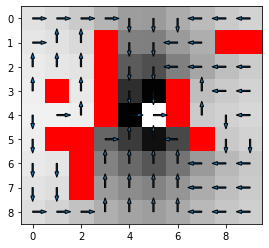

74


AssertionError: ignored

In [ ]:
import random; import numpy.random; random.seed(0); numpy.random.seed(0);
assert MDP_8() == ({(5, 9): 14.420715446050961, (4, 7): 13.902821528732161, (6, 9): 17.522051696882965, (7, 3): 31.838253212176514, (4, 8): 13.667136824464677, (3, 0): 2.9777487916630037, (0, 2): 0.9001326817070744, (2, 8): 16.99898779596241, (5, 6): 58.44514637931084, (6, 6): 44.30302412606489, (7, 7): 26.537680766830544, (0, 7): 15.743800555462956, (2, 1): 1.6172851771174923, (8, 0): 10.903039249577581, (8, 9): 15.254251627728882, (1, 6): 24.055886273939368, (3, 7): 17.07090407740291, (0, 3): 0.5785581189251501, (2, 5): 46.774413201257964, (8, 5): 30.863210637713184, (5, 8): 16.990601179360855, (4, 0): 3.9184650739881026, (1, 2): 1.1524036502717687, (4, 9): 12.160651720661061, (5, 5): 76.14699816301615, (2, 9): 13.495295853698757, (6, 7): 32.14896909433096, (8, 1): 14.005081464899975, (7, 6): 33.93824516773491, (4, 4): 80.37663096925165, (6, 3): 39.539298105045916, (1, 5): 23.389443634226886, (5, 0): 5.403179134534879, (2, 2): 1.444317292844642, (0, 4): 0.0, (8, 6): 27.3623564363111, (4, 1): 3.0175170488819, (1, 1): 1.2977193193898395, (6, 4): 47.3490864812608, (3, 2): 1.805072518669852, (0, 0): 1.2453233119401066, (2, 6): 33.05239375552657, (5, 4): 61.9373307400009, (8, 2): 19.342794017533976, (7, 1): 10.430732207135575, (4, 5): 0.0, (6, 0): 7.098824399118802, (1, 4): 10.028303446172764, (3, 9): 11.981098835582827, (0, 5): 15.606385378759894, (7, 5): 39.445864503050224, (8, 7): 22.375414935331435, (4, 2): 2.3265722466755614, (1, 0): 1.58216541245288, (0, 8): 12.272723681582853, (6, 5): 53.930845049952254, (3, 5): 77.70082200009756, (0, 1): 1.0655389396862487, (2, 7): 22.917774884181394, (5, 3): 48.28956184056703, (7, 8): 20.57876145946384, (7, 0): 8.865640273627962, (6, 8): 22.730746278025983, (7, 9): 16.67868907115209, (8, 3): 25.420434635478415, (6, 1): 8.22663634201134, (3, 8): 14.0789880917416, (0, 6): 18.26785427695802, (2, 0): 2.141003137871459, (7, 4): 36.37844344412177, (8, 8): 18.16927838465352, (1, 7): 19.55809928017202, (0, 9): 10.041316763513615, (3, 4): 60.19691176793037, (2, 4): 22.28511887235979, (8, 4): 29.19158296257332}, 81)
print('Tests passed.')

### MDP Question 9

Now let's make the dynamics a little more sane again, but let's make the
hazard really hazardous. Please create a LargeRescueMDP, set a hazard at `{(1,
4)}', set correct_transition_probability to be .76 and set the hazard_cost to
be -500 (remember the default values is -100). Then please solve for the
optimal value function.

<div class="question question-multiplechoice">
<b>Submission Material 9:</b> In your submitted pdf, please include a single
plot of the value function with the action under the optimal policy drawn for
each state. Name this figure as Figure 9.

In your pdf, please also answer the following questions:

* Compared to the previous question, with the less noisy dynamics but the
greater hazard, the policy didn't change. Why not?

<!-- Even thought the dynamics are more deterministic, the expected cost
calculation now reflects a higher risk, so it's still cheaper for all the
states to the left of (0, 4) to go down and around, to avoid the large
negative hazard. --> 

* At the state (0, 3), you should see that the policy from state (0, 3) still
goes to the left, even though it's a much shorter path to the goal to go
right. To the nearest 25 (e.g., -225, -250, -275, etc.), what is the largest
value of hazard_cost before the agent starts heading left
from (0, 3)? (We're expecting you to work this out experimentally, not
derive the answer mathematically.)

<!-- The arrow flips from -330 to -331, so -325 would be the largest value
before it flips. 
-->

</div>


For reference, our solution is **5** lines of code.

In [ ]:
def MDP_9():
  """Creates a LargeRescueMDP(), sets a hazard at `{(1, 4)}', the hazard_cost
  to -500 and returns the optimal value function and number of iterations
  required to converge

  Args:
    None

  Returns:
    value function: a dict of states to values
    it: the number of iterations required to solve for the value function
  """
  mdp = LargeRescueMDP()
  mdp.correct_transition_probability = 0.76
  mdp.hazard_cost = -500
  mdp.hazard={(1,4)}
  re = value_iteration(mdp)
  plot_value_function(re[0],mdp)
  print(re[1])
  return re

Tests

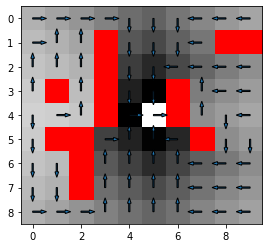

41


AssertionError: ignored

In [ ]:
import random; import numpy.random; random.seed(0); numpy.random.seed(0);
assert MDP_9() == ({(5, 9): 37.04691384411, (4, 7): 39.06371443171, (6, 9): 42.361449207358575, (7, 3): 53.44864721100319, (4, 8): 36.87593522361095, (3, 0): 14.079883066986167, (0, 2): 6.884984998491514, (2, 8): 44.98800527355933, (5, 6): 80.37100030462571, (6, 6): 69.15428040445741, (7, 7): 51.397483564240524, (0, 7): 40.719858955066805, (2, 1): 10.209846017254346, (8, 0): 29.39066300148473, (8, 9): 34.8065288085131, (1, 6): 53.52714520097443, (3, 7): 45.005076359811184, (0, 3): 5.501499785655442, (2, 5): 74.0627430791277, (8, 5): 57.12632181502593, (5, 8): 42.22190439196624, (4, 0): 16.361484736597472, (1, 2): 7.947653406161168, (4, 9): 32.83788462997579, (5, 5): 93.30185390613893, (2, 9): 38.84368709824219, (6, 7): 58.79989507298079, (8, 1): 34.08117435403343, (7, 6): 59.52251652186371, (4, 4): 94.29103714575145, (6, 3): 61.26297454045764, (1, 5): 53.76915433730857, (5, 0): 19.232225804261198, (2, 2): 9.12692147403646, (0, 4): 0.0, (8, 6): 51.814600301509564, (4, 1): 14.095341831350655, (1, 1): 8.845961519726597, (6, 4): 70.0264902643615, (3, 2): 10.471424720782824, (0, 0): 8.787998404563115, (2, 6): 62.84087542660175, (5, 4): 81.30332392219262, (8, 2): 40.08633184523097, (7, 1): 29.057654093080977, (4, 5): 0.0, (6, 0): 22.346138410489985, (1, 4): 14.782015804707825, (3, 9): 34.42223002662499, (0, 5): 43.1977509916744, (7, 5): 66.52387067026784, (8, 7): 45.242397371014604, (4, 2): 12.143870517865647, (1, 0): 10.18354941089174, (0, 8): 35.114670719925776, (6, 5): 78.629202248007, (3, 5): 93.72926794239754, (0, 1): 7.736062903365366, (2, 7): 52.825856610909575, (5, 3): 70.11963519812882, (7, 8): 44.347739033652914, (7, 0): 25.651170798064065, (6, 8): 49.50216689379373, (7, 9): 38.67451282808284, (8, 3): 46.57902852297769, (6, 1): 25.098548250123248, (3, 8): 39.15607649476454, (0, 6): 45.96404658532311, (2, 0): 11.96008595355823, (7, 4): 60.31638851324104, (8, 8): 39.48804641975247, (1, 7): 46.71105477963087, (0, 9): 30.63575861789443, (3, 4): 78.4478215120539, (2, 4): 21.611134217490232, (8, 4): 52.503442851936725}, 51)
print('Tests passed.')